<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#The-traces-and-the-protocol" data-toc-modified-id="The-traces-and-the-protocol-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The traces and the protocol</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#All-the-traces" data-toc-modified-id="All-the-traces-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>All the traces</a></span></li><li><span><a href="#Variational-protocol" data-toc-modified-id="Variational-protocol-2.0.0.2"><span class="toc-item-num">2.0.0.2&nbsp;&nbsp;</span>Variational protocol</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Preamble

In [12]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

In [13]:
epsilon = 10e-10
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 2.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

# The traces and the protocol

In [21]:
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.010

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.050
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

2.4508337869092762

In [22]:
colors_ink = ['', '#aa8800ff', '#ffcc00ff', '#ffe680ff', '#fff6d5ff']
letters = [r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$']


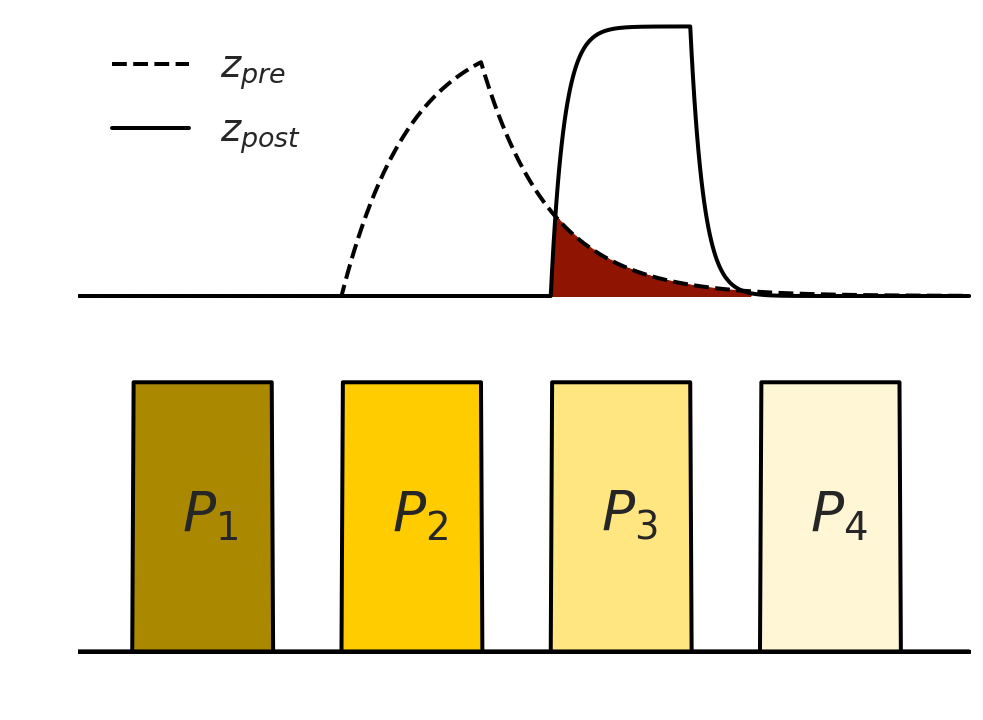

In [23]:
save = True

o_set = timed_input.O.T
z_set = timed_input.z_pre.T
z_set_post = timed_input.z_post.T


linewidth = 4
time = np.arange(0, manager.T_training_total, dt)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot the traces
z_pre = z_set[:, 2]
z_post = z_set_post[:, 3]
ax1.plot(time, z_pre, linewidth=linewidth, ls='--', color='black', label=r'$z_{pre}$')
ax1.plot(time, z_post, linewidth=linewidth, ls='-', color='black', label=r'$z_{post}$')

# Fill the gap
color = '#8f1402'
where = (z_post > 0.010)
aux = np.min(np.vstack((z_pre,z_post)), axis=0)
ax1.fill_between(time, aux, where=where, interpolate=True, step='post', color=color)

# Plot the protocol
for index, o in enumerate(o_set.T):
    ax2.plot(time, o, linewidth=linewidth, ls='-', color='black', label=r'$o_1$')
    ax2.fill_between(time, o, 0, color=colors_ink[index])

# Set the x-limes
x_start = training_times_base + tau_s
x_end = (training_times_base + ipi_base) * n_patterns 

# Letters
start = training_times_base + ipi_base + 0.035
jump = training_times_base + ipi_base

for index, letter in enumerate(letters):
    ax2.text(start + index * jump, 0.45, letter, size=55)

#ax2.legend(frameon=False)
ax1.legend(frameon=False, loc=2)
ax1.set_xlim([x_start, x_end])
ax2.set_xlim([x_start, x_end])

if True:
    ax1.axis('off')
    ax2.axis('off')

if save:
    directory = '../plot_producers/'
    file_name = 'protocol' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

#### All the traces

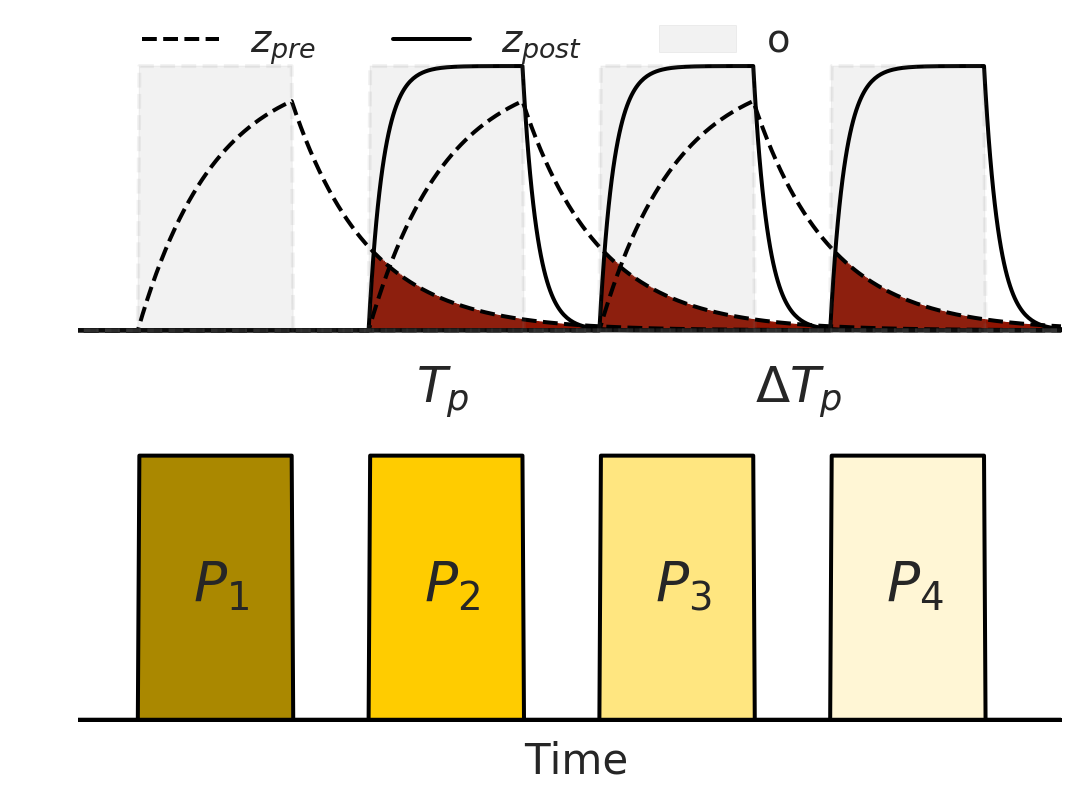

In [67]:
save = True

o_set = timed_input.O.T
z_set = timed_input.z_pre.T
z_set_post = timed_input.z_post.T



linewidth = 4
time = np.arange(0, manager.T_training_total, dt)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


# Plot the traces
for index in range(1, n_patterns - 1):
    if index == 1:
        pre_label = r'$z_{pre}$'
        post_label = r'$z_{post}$'
        fill_label = None # r'$w_{next}$'
    else:
        pre_label = None
        post_label = None
        fill_label = None
    z_pre = z_set[:, index]
    z_post = z_set_post[:, index + 1]
    ax1.plot(time, z_pre, linewidth=linewidth, ls='--', color='black', label=pre_label)
    ax1.plot(time, z_post, linewidth=linewidth, ls='-', color='black', label=post_label)

    # Fill the gap
    color = colors_ink[index]
    color = '#8f1402'
    where = (z_post > 0.010)
    aux = np.min(np.vstack((z_pre,z_post)), axis=0)
    ax1.fill_between(time, aux, where=where, interpolate=True, step='post', color=color)

# Plot the protocol
color_o = 'gray'
alpha_o = 0.1
# ax1.plot(time, o_set[:, 0], linewidth=linewidth, ls='--', color=color_o, alpha=alpha_o, label='o')
ax1.fill_between(time, 0.0 * o_set[:, 0], 0, color=color_o, alpha=alpha_o, label='o')

for index, o in enumerate(o_set.T):
    ax2.plot(time, o, linewidth=linewidth, ls='-', color='black')
    ax2.fill_between(time, o, 0, color=colors_ink[index])
    
    ax1.plot(time, o, linewidth=linewidth, ls='--', color=color_o, alpha=alpha_o)
    ax1.fill_between(time, o, 0, color=color_o, alpha=alpha_o)

# Set the x-limes
x_start = training_times_base + tau_s
x_end = (training_times_base + ipi_base) * n_patterns 
ax1.set_xlim([x_start, x_end])
ax2.set_xlim([x_start, x_end])

# Letters
start = training_times_base + ipi_base + 0.035
jump = training_times_base + ipi_base
for index, letter in enumerate(letters):
    ax2.text(start + index * jump, 0.45, letter, size=55)

ax2.text(0.400, -0.2, 'Time')
ax1.legend(frameon=False, loc=(0.05, 0.9), ncol=3)

# ax2.text(0.300, 0.9, r'$\{$', rotation = 270, fontsize=150)
ax2.text(0.330, 1.2, r'$T_{p}$', fontsize=50)
ax2.text(0.550, 1.2, r'$\Delta T_{p}$', fontsize=50)


if True:
    ax1.axis('off')
    ax2.axis('off')
    
fig.tight_layout()

if save:
    directory = '../plot_producers/'
    file_name = 'protocol_all' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

#### Variational protocol

In [18]:
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.010

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns


# Training protocol
training_times = [0.100, 0.100, 0.050, 0.200, 0.100]
ipi_base = 0.050
inter_pulse_intervals = [0.050, 0.025, 0.050, 0.100, 0.100]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

2.1707778931752175

0.15000000000000002
0.275
0.375
0.675


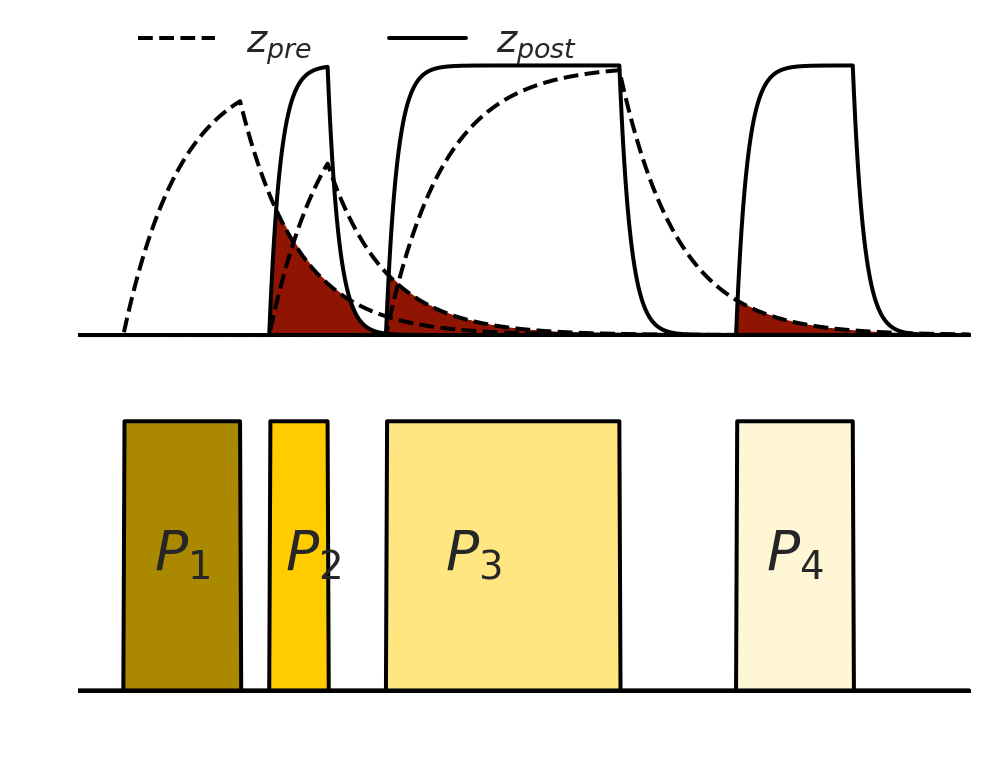

In [19]:
save = True

o_set = timed_input.O.T
z_set = timed_input.z_pre.T
z_set_post = timed_input.z_post.T


linewidth = 4
time = np.arange(0, manager.T_training_total, dt)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot the traces
for index in range(1, n_patterns - 1):
    if index == 1:
        pre_label = r'$z_{pre}$'
        post_label = r'$z_{post}$'
        fill_label = None
    else:
        pre_label = None
        post_label = None
        fill_label = None
    z_pre = z_set[:, index]
    z_post = z_set_post[:, index + 1]
    ax1.plot(time, z_pre, linewidth=linewidth, ls='--', color='black', label=pre_label)
    ax1.plot(time, z_post, linewidth=linewidth, ls='-', color='black', label=post_label)

    # Fill the gap
    color = colors_ink[index]
    color = '#8f1402'
    where = (z_post > 0.010)
    aux = np.min(np.vstack((z_pre,z_post)), axis=0)
    ax1.fill_between(time, aux, where=where, interpolate=True, step='post', color=color, label=fill_label)

ax1.legend(frameon=False, loc=(0.05, 0.9), ncol=3)

# Plot the protocol
for index, o in enumerate(o_set.T):
    ax2.plot(time, o, linewidth=linewidth, ls='-', color='black', label=r'$o_1$')
    ax2.fill_between(time, o, 0, color=colors_ink[index])

# Set the x-limes
x_start = training_times[0] + tau_s
x_end = sum(training_times) + sum(inter_pulse_intervals) 
ax1.set_xlim([x_start, x_end])
ax2.set_xlim([x_start, x_end])

# Letters
x_letter = 0.00
for index, letter in enumerate(letters):
    x_letter += training_times[index] + inter_pulse_intervals[index]
    print(x_letter)
    offset = training_times[index + 1] * 0.25
    ax2.text(x_letter + offset, 0.45, letter, size=55)
    
#ax2.legend(frameon=False)


if True:
    ax1.axis('off')
    ax2.axis('off')

if save:
    directory = '../plot_producers/'
    file_name = 'protocol_var' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')